## What is this notebook about?

This notebook was used to create ```Fig.3```, ```Table B2``` in the appendix and the analyis numbers of the self-assessments referenced in the text.

The numbers calculated here and other notebooks will be stored under the filepath indicated by the variable `data_reports_fp` for future reference.

In [1]:
# Some imports to get things started
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

sys.path.insert(1, os.path.abspath('../'))
from utils import set_aspect,save_descriptive_stats, save_variables
from pathlib import Path

In [2]:
# Load the questionnaire answers 
survey_info = pd.read_excel(Path('../data/survey.xlsx'))

# Turn the upper and lower scale labels into numerical values
survey_info.replace({'Disagree strongly = 1': 1, 'Agree strongly = 7': 7, 'No answer': np.nan}, inplace=True)

# Where to save numbers from the analysis
data_reports_fp = Path('../reports/numbers.dat')

# Where to save figures from the analysis
figpath = Path('../reports')

In [3]:
def cronbachs_alpha(items):
    
    # Remove rows where one of the items is unanswered
    items = items.dropna(how='any')
    
    # Calculate variance for each column
    item_variances = [np.nanvar(items[col], ddof=1) for col in items.columns]
    
    # Calculate total variance of the summed items across all rows (respondents)
    total_variance = np.nanvar(np.sum(items, axis=1), ddof=1)
    
    
    # Number of items (columns)
    k = len(items.columns)
    
    # Cronbach's alpha formula
    alpha = (k / (k - 1)) * (1 - sum(item_variances) / total_variance)
    
    return alpha

## Perceived impact - Fig. 3A

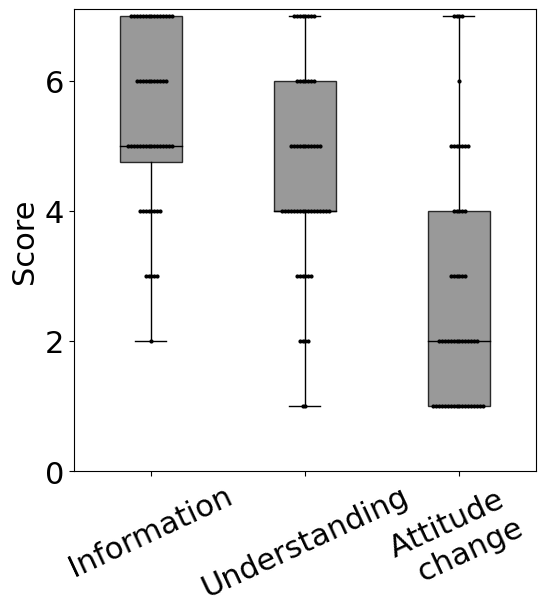

In [4]:
# DataFrame columns associated with Perceived impact
columns = ['Informativeness','Better understanding','Attitude change','Increase frequency','Decrease frequency']

# Aspects that are summarized on the plot
plot_columns = ['Informativeness','Better understanding','Attitude change']

# Getting started for the plot
fig, ax = plt.subplots(figsize=(6,6))
positions = np.arange(len(plot_columns))

for ind,col in enumerate(columns):
    data = survey_info[col].dropna().values
    save_descriptive_stats(data_reports_fp,col,data)
    if col in plot_columns:
        x = positions[ind] # position of the boxplot
        box_negative = ax.boxplot(data,positions=[x],sym = 'D',
                                  patch_artist=True,widths=0.4,boxprops=dict(facecolor='gray',alpha=.8))

        # Plot the data points as small dots
        for median in box_negative['medians']:
            median.set_color('black')
        data = pd.Series(data)
        unique_values = data.value_counts()
        for item in unique_values.index:
            sign = 1
            for i in range(unique_values[item]):
                ax.plot(x+sign*i*0.01,item,'k.', markersize=4)
                sign = sign*-1
                
    ax.set_ylabel('Score',fontsize=22)
    ax.set_xticks(positions)
    ax.set_xticklabels(['Information','Understanding','Attitude \n change'],rotation=25)
    ax.tick_params(axis='both', which='major', labelsize=22)
    ax.set_ylim(0,7.1)
    set_aspect(ax)
    fig.patch.set_facecolor('white')
    fig.savefig(Path(f'{figpath}/perceived-impact.svg'),dpi=500,bbox_inches = 'tight')
    fig.savefig(Path(f'{figpath}/perceived-impact.png'),dpi=500,bbox_inches = 'tight')
    
# Calculate and save Cronbach's alpha    
alpha = cronbachs_alpha(survey_info[plot_columns])
save_variables(data_reports_fp, 'perceived_impact_alpha',alpha)

## User experience - Fig. 3B, Table B2

In [5]:
# DataFrame columns associated with user experience evaluation separated by pragmatic and hedonic qualities
pragmatic = ['Obstructive|Supportive','Complicated|Easy','Inefficient|Efficient','Confusing|Clear']
hedonic = ['Boring|Exciting','Not interesting|Interesting','Conventional|Inventive','Usual|Leading edge']
columns = pragmatic+hedonic
pragmatic_values = []
hedonic_values = []

for ind,col in enumerate(columns):
    data = survey_info[col].dropna().values
    save_descriptive_stats(data_reports_fp,col,data)
    if col in pragmatic:
       pragmatic_values.append(data)
    elif col in hedonic:
        hedonic_values.append(data)
        
 # Use the means of the different qualities for aggregated pragmatic, hedonic and overall scores     
pragmatic_scores = np.mean(pragmatic_values,axis=0)
hedonic_scores = np.mean(hedonic_values, axis=0)
overall_scores = np.mean(pragmatic_values+hedonic_values,axis=0)

# Calculate and save Cronbach's alpha    

alpha_pragmatic = cronbachs_alpha(survey_info[pragmatic])
alpha_hedonic = cronbachs_alpha(survey_info[hedonic])
alpha_overall = cronbachs_alpha(survey_info[columns])
save_variables(data_reports_fp, 'pragmatic_alpha',alpha_pragmatic)
save_variables(data_reports_fp, 'hedonic_alpha',alpha_hedonic)
save_variables(data_reports_fp, 'UEQ_alpha',alpha_overall)

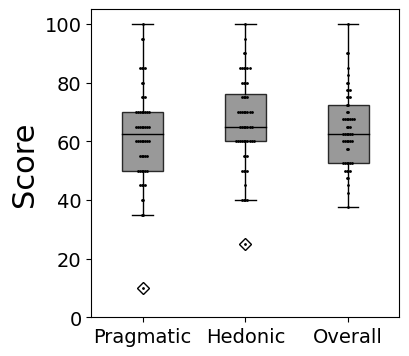

In [6]:
# Plotting the boxplot of Figure 3B
positions = np.arange(len(plot_columns))
labels = ['Pragmatic','Hedonic','Overall']
fig, ax = plt.subplots(figsize=(4,4))

for ind,(data,label) in enumerate(zip([pragmatic_scores,hedonic_scores,overall_scores],labels)):
    save_descriptive_stats(data_reports_fp,label,data)
    x = positions[ind] # position of the boxplot
    box_negative = ax.boxplot(data,positions=[x],sym = 'D',
                      patch_artist=True,widths=0.4,boxprops=dict(facecolor='gray',alpha=.8))

    # Plot the data points as small dots 
    for median in box_negative['medians']:
        median.set_color('black')
    data = pd.Series(data)
    unique_values = data.value_counts()
    for item in unique_values.index:
        sign = 1
        for i in range(unique_values[item]):
            ax.plot(x+sign*i*0.01,item,'k.', markersize=2)
            sign = sign*-1
            
    ax.set_ylabel('Score',fontsize=22)
    ax.set_xticks(positions)
    ax.set_xticklabels(labels)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_ylim(0,105)
    set_aspect(ax)
    fig.patch.set_facecolor('white')
    fig.savefig(Path(f'{figpath}/UEQ.svg'),dpi=500)
    fig.savefig(Path(f'{figpath}/UEQ.png'),dpi=500)



## Relation to life events - Fig. 3C

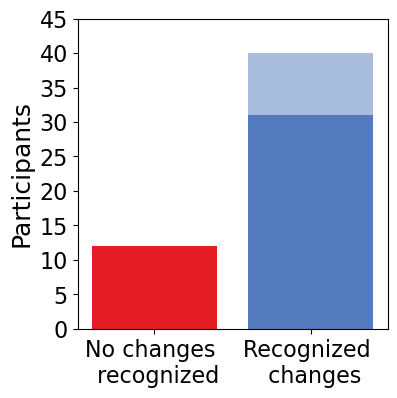

In [7]:
# Separate positive and negative responses

yes_option = 'I could recognize changes of my messaging behavior over time.'
no_option = 'I could not recognize any changes of my messaging behavior over time.'
yes_responses = survey_info[survey_info['Recognized behavior changes']==yes_option]
no_responses = len(survey_info[survey_info['Recognized behavior changes']==no_option])

# Separate positive and negative responses to the relation to life events
life_relation_yes= 'I was able to relate these changes to relevant events in my life.'
life_relation_no = 'I was not able to relate these changes to relevant events in my life.'
life_relation = len(yes_responses[yes_responses['Life event relation']==life_relation_yes])
no_life_relation = len(yes_responses[yes_responses['Life event relation']==life_relation_no])


yes_color = '#537BBE'
no_color = '#E41D25'
no_memory_alpha = 0.5


fig, ax = plt.subplots(figsize=(4,10))
ax.bar(0,no_responses,color=no_color)
ax.bar(1,life_relation,color=yes_color)
ax.bar(1,no_life_relation, color=yes_color,alpha=no_memory_alpha, bottom=life_relation-0.05)
ax.set_ylabel('Participants',fontsize=18)
ax.set_xticks([0,1])
ax.set_xticklabels(['No changes \n recognized','Recognized \n changes'])
y_ticks = [int(item) for item in ax.get_yticks()]
ax.set_yticks(y_ticks)
ax.tick_params(axis='both', which='major', labelsize=16)
set_aspect(ax)
fig.savefig(Path(f'{figpath}/observed-changes.svg'),dpi=500,bbox_inches='tight')
fig.savefig(Path(f'{figpath}/observed-changes.png'),dpi=500,bbox_inches='tight')

save_variables(data_reports_fp,'N_no_changes_recognized',no_responses)
save_variables(data_reports_fp,'N_changes_recognized',len(yes_responses))
save_variables(data_reports_fp,'N_no_relation_recognized',no_life_relation)
save_variables(data_reports_fp,'N_relation_recognized',life_relation)


## Scores on whether the participants would recommend the study

In [8]:
recommending = survey_info['Recommendation score']
save_descriptive_stats(data_reports_fp,'recommendation-score',recommending)